# House Prices: Advanced Regression Techniques

## 資料前處理 (懶人法)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

train  = pd.read_csv("./house prices/train.csv")
test = pd.read_csv("./house prices/test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

# Data Preprocessing
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.median())
    
train["SalePrice"] = np.log1p(train["SalePrice"])

scaler = StandardScaler().fit(all_data[numeric_feats])
all_data[numeric_feats] = scaler.transform(all_data[numeric_feats])
    
#creating matrices for sklearn:
X = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

# Lasso Model

alpha = 0.000001, rmse = 0.138651
alpha = 0.000010, rmse = 0.137185
alpha = 0.000100, rmse = 0.128807
alpha = 0.001000, rmse = 0.123366
alpha = 0.010000, rmse = 0.141547
alpha = 0.100000, rmse = 0.215882
alpha = 1.000000, rmse = 0.399226


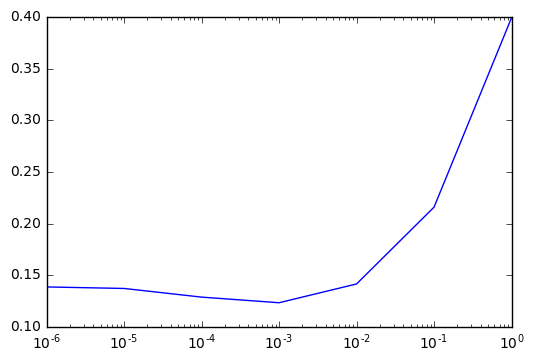

In [74]:
from sklearn.linear_model import Lasso, LassoCV
model_lasso = Lasso()

from sklearn.model_selection import cross_val_score

rmse = []

def rmse_cv(X, y):
    rmse_list = []
    alphas = []
    for alpha in np.arange(-6, 1):    
        rmse = np.sqrt(-cross_val_score(Lasso(alpha=10**alpha), X, y, scoring="neg_mean_squared_error", cv = 5))
        print 'alpha = %f, rmse = %f' % (10**alpha, rmse.mean())    
        alphas.append(10**alpha)
        rmse_list.append(rmse.mean())
    return rmse_list, alphas

rmse, alphas = rmse_cv(X, y)

cv_lasso = pd.Series(rmse, index=alphas)
cv_lasso.plot(logx=True)
plt.show()

## 或是用內建的cv function，找最好的alpha

In [75]:
model_lasso_cv = LassoCV(alphas=alphas)
model_lasso_cv.fit(X, y)
print 'best alpha = %f' % (model_lasso_cv.alpha_)

best alpha = 0.001000


## Summit Kaggle分數

- Lasso(alpha=0.001) 
- train rmse = 0.109834
- valid rmse = 0.131791
- public score = 0.15588

# NN

- 先確定有over-fitting，再去想Early Stopping, Regularization, Dropout等工具

In [76]:
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

## keras callback function

* 改寫成rmse計算方式

In [77]:
p = X.shape[1]
x_train = X.values
y_train = y.values

In [78]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(np.sqrt(logs.get('loss')))
        self.val_losses.append(np.sqrt(logs.get('val_loss')))
        #print 'rmse loss = %f, val_loss = %f' % (np.sqrt(logs.get('loss')), np.sqrt(logs.get('val_loss')))        

## 用GridSearch找NN神經元

In [79]:
def create_model(neurons=10):    
    model = Sequential()
    
    # 第一層hidden layer
    model.add(Dense(input_dim=p, output_dim=neurons))
    model.add(Activation('relu'))            
        
    # output layer            
    model.add(Dense(output_dim=1))
    model.add(Activation('relu'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [80]:
neurons = [10, 30, 100, 200]
param_grid = dict(neurons=neurons)
model = KerasRegressor(build_fn=create_model, nb_epoch=100, batch_size=10, validation_split=0.2, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(x_train, y_train)

In [81]:
rmses = np.sqrt(grid_result.cv_results_['mean_test_score'])

In [82]:
rmses = np.sqrt(grid_result.cv_results_['mean_test_score'])
params = grid_result.cv_results_['params']
for rmse, param in zip(rmses, params):
    print "%f with: %r" % (rmse, param)

0.173748 with: {'neurons': 10}
0.223783 with: {'neurons': 30}
0.204948 with: {'neurons': 100}
0.236030 with: {'neurons': 200}


## hidden layer 10個神經元比較好，畫個圖看看

In [83]:
model = create_model()
history = LossHistory()
hist = model.fit(x_train, y_train, nb_epoch=600, batch_size=10, validation_split=0.2, callbacks=[history], verbose=0)

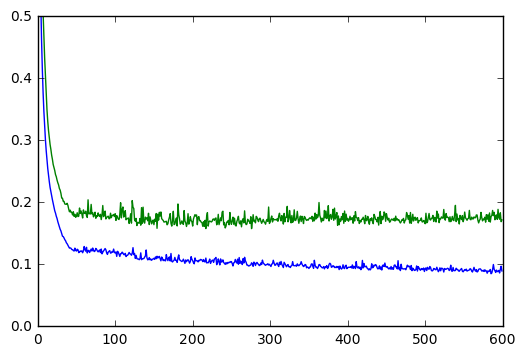

In [84]:
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.ylim([0, 0.5])
plt.show()

## output (把Lasso和NN加在一起)

In [85]:
lasso_pred = np.expm1(model_lasso_cv.predict(X_test))
dnn_pred = np.expm1(model.predict(X_test.values))
dnn_pred = dnn_pred[:, 0]

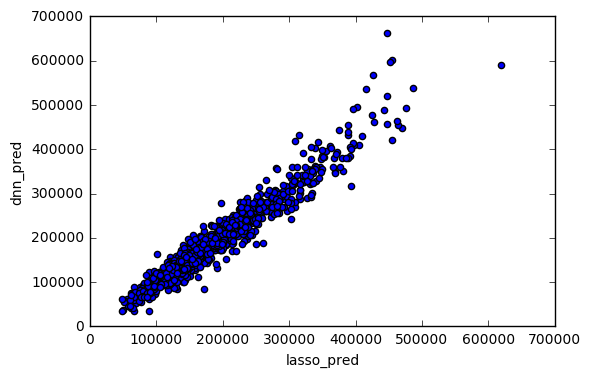

1.0


In [89]:
df = pd.DataFrame({"lasso_pred":lasso_pred,"dnn_pred":dnn_pred})
df.plot(x = "lasso_pred", y = "dnn_pred", kind = "scatter")
plt.show()

In [87]:
preds = 0.7*lasso_pred + 0.3*dnn_pred

pred_df = pd.DataFrame(preds, index=test["Id"], columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')